In [1]:
from bindingcalculator import BindingCalculator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Mutation level analysis

In [2]:
# instantiate binding calculator based on escape data
# https://github.com/jbloomlab/SARS2_RBD_Ab_escape_maps/
bindcalc = BindingCalculator(csv_or_url='./escape_calculator_data.csv',
                             eliciting_virus='SARS-CoV-2',
                             source_lab='all',
                             neutralizes_Omicron='either',
                             metric='sum of mutations at site',
                             mutation_escape_strength=2.0)
sites = bindcalc.sites
print("A total of {} RBD sites have escape data".format(len(bindcalc.sites)))

A total of 201 RBD sites have escape data


In [3]:
# ingest pyro-cov inferences
mutations = pd.read_csv('../paper/mutations.tsv', sep='\t')
# filter to S gene only
mutations = mutations[[m[:2]=='S:' for m in mutations.mutation]]
print("Our model considers {} mutations in the S gene.".format(len(mutations)))
# filter to sites that we have escape data for
mutations = mutations[[int(m[3:-1]) in sites for m in mutations.mutation]]
sites = [int(m[3:-1]) if int(m[3:-1]) in sites else None for m in mutations.mutation]
print("Of these, {} mutations have escape data:".format(len(sites)))
print(sites)

Our model considers 321 mutations in the S gene.
Of these, 41 mutations have escape data:
[484, 501, 452, 477, 417, 478, 490, 439, 452, 484, 440, 501, 520, 346, 494, 478, 522, 346, 449, 414, 411, 484, 450, 452, 385, 479, 446, 486, 357, 481, 477, 384, 445, 483, 382, 493, 522, 408, 477, 453, 417]


In [4]:
#binding = [-np.log(bindcalc.binding_retained([s])) for s in sites]
binding = np.array([1 - bindcalc.binding_retained([s]) for s in sites])
inferred_log_growth = mutations['Δ log R'].values
#inferred_log_growth = inferred_log_growth[binding > 0.03]
#binding = binding[binding > 0.03]

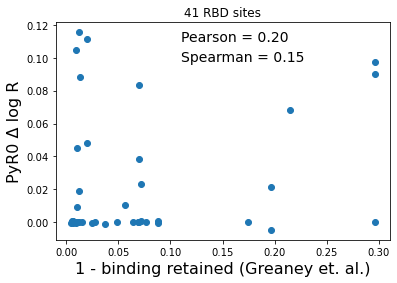

In [5]:
pearson = stats.pearsonr(binding, inferred_log_growth)[0]
spearman = stats.spearmanr(binding, inferred_log_growth)[0]

plt.scatter(binding, inferred_log_growth)
plt.xlabel("1 - binding retained (Greaney et. al.)", fontsize=16)
plt.ylabel("PyR0 Δ log R", fontsize=16)
plt.text(0.11, 0.11, "Pearson = {:.2f}".format(pearson), fontsize=14)
plt.text(0.11, 0.098, "Spearman = {:.2f}".format(spearman), fontsize=14)
plt.title("{} RBD sites".format(len(binding)))
plt.show()

## Variant level analysis

In [6]:
def compute_agg_logR(variant):
    logR = 0.0
    for m in variant:
        logRs = mutations[[int(x[3:-1])==m for x in mutations.mutation]]['Δ log R'].values
        # TODO: use actual mutation in variant not mean
        logR += 0.0 if len(logRs) ==0 else logRs.mean()
    return logR

In [7]:
omicron = [339, 371, 373, 375, 417, 440, 446, 477, 478, 484, 493, 496, 498, 501, 505]
alpha = [501]
betagamma = [417, 484, 501]  # beta == gamma at rbd
delta = [452, 478]
lambd = [452, 490]
mu = [346, 484, 501] 
variants = [omicron, alpha, betagamma, delta, lambd, mu]
names = ['omicron', 'alpha', 'beta/gamma', 'delta', 'lambda', 'mu']

In [8]:
pyro_logR = [compute_agg_logR(variant) for variant in variants]
binding = [1 - bindcalc.binding_retained(variant) for variant in variants]

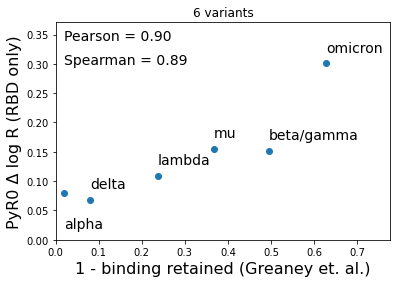

In [9]:
pearson = stats.pearsonr(binding, pyro_logR)[0]
spearman = stats.spearmanr(binding, pyro_logR)[0]

plt.scatter(binding, pyro_logR)
plt.xlabel("1 - binding retained (Greaney et. al.)", fontsize=16)
plt.ylabel("PyR0 Δ log R (RBD only)", fontsize=16)
plt.text(0.02, 0.34, "Pearson = {:.2f}".format(pearson), fontsize=14)
plt.text(0.02, 0.30, "Spearman = {:.2f}".format(spearman), fontsize=14)
plt.title("{} variants".format(len(binding)))
plt.ylim(0.0, max(pyro_logR) + 0.07)
plt.xlim(0.0, max(binding) + 0.15)

for i in range(len(binding)):
    adjust = -0.08 if names[i] == 'alpha' else 0.0
    plt.annotate(names[i], (binding[i], pyro_logR[i]+0.02+adjust), fontsize=14)
    
plt.show()